In [35]:
import pandas as pd
import numpy as np
from pathlib import Path

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

import seaborn as sns
import plotly.express as ex
import plotly.figure_factory as ff


In [2]:

starter_df = pd.read_csv(Path("./Resources/BankChurners2.csv"))

starter_df = starter_df[starter_df != 'Unknown'].dropna()
starter_df.sample(5)


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
9624,715600533,Existing Customer,61,M,0,Graduate,Single,$80K - $120K,Gold,50,...,34516.0,1357,33159.0,0.687,13722,124,0.746,0.039,0.000299,0.999700
10016,718840833,Attrited Customer,49,M,3,High School,Single,$40K - $60K,Blue,36,...,4601.0,0,4601.0,0.962,9610,76,0.689,0.000,0.998080,0.001916
4510,719917233,Attrited Customer,49,M,3,Post-Graduate,Married,$80K - $120K,Blue,36,...,13382.0,1159,12223.0,0.404,1828,45,0.500,0.087,0.995470,0.004532
5736,768544833,Existing Customer,45,F,4,Uneducated,Single,Less than $40K,Blue,39,...,2202.0,1414,788.0,0.593,4531,77,0.540,0.642,0.000206,0.999790
8860,719258433,Existing Customer,49,M,5,Graduate,Single,$60K - $80K,Blue,42,...,7801.0,2018,5783.0,0.684,7561,91,0.685,0.259,0.000096,0.999900


In [3]:
starter_df['Education_Level'].value_counts()

Graduate         2591
High School      1653
Uneducated       1204
College           844
Post-Graduate     431
Doctorate         358
Name: Education_Level, dtype: int64

In [4]:
#Shorten column names so they display better
replacement_column_names = {'Attrition_Flag': 'Status',
        'Customer_Age': 'Age',
        'Education_Level': 'Education',
        'Dependent_count': 'Dependents',
        'Income_Category': 'Income',
        'Card_Category': 'Card Type',
        'Months_on_book': 'Tenure(month)'
        }
starter_df.rename(columns=replacement_column_names, inplace=True)

In [5]:
#Drop unknowns
starter_df = starter_df[starter_df.Marital_Status != 'Unknown']
starter_df = starter_df[starter_df.Education != 'Unknown']
starter_df = starter_df[starter_df.Income != 'Unknown']

#NOT USING RIGHT NOWReplace M/F with -1/1
#starter_df = starter_df.replace({'Gender' : {'M': '-1', 'F': '1'}})

#Replace M/F with 0,1
starter_df = starter_df.replace({'Gender' : {'M': 0, 'F': 1}})

#Replace customer's status to 0 if they left and 1 if they stayed
starter_df = starter_df.replace({'Status' : {'Attrited Customer': -1, 'Existing Customer': 1}})





In [6]:
"""
use feature creation to make a ratio between dependents and income sources
consider someone divorced as Single. only 10% of divorced people receive alimony payments
        either a 1 (single/divorced) or a 2 (married)
        divide that by the amount of dependents plus one, which represents how many people you take care of
                i.e. a single person with no dependents only takes care of themself, so they are a 1. 
                """
starter_df = starter_df.replace({'Marital_Status' : {'Divorced': 1, 'Single': 1, 'Married' : 2}})
starter_df['MaritalDependentRatio'] = ((starter_df['Marital_Status'] / (starter_df['Dependents'] + 1)) / 2).round(2)
starter_df.drop(columns=['Marital_Status', 'Dependents'], inplace=True)

#Replace card categories from Blue/Silver/Gold/Plat to 0/1/2/3/4
starter_df = starter_df.replace({'Card Type' : {'Blue': 0, 'Silver': 1, 'Gold' : 3, 'Platinum' : 4}})


#Drop irrelevant column
starter_df = starter_df.drop(columns='CLIENTNUM')

In [7]:
#use feature creation to make a ratio between avg open to buy and credit limit

starter_df['CreditUsage'] = (starter_df['Avg_Open_To_Buy'] / starter_df['Credit_Limit']).round(2)
starter_df.drop(columns=['Avg_Open_To_Buy', 'Credit_Limit'], inplace=True)

In [8]:
#use feature creation to make a ratio between transaction amount and trans count
starter_df['AvgTransValue'] = (starter_df['Total_Trans_Amt'] / starter_df['Total_Trans_Ct']).round(2)
starter_df.drop(columns=['Total_Trans_Amt', 'Total_Trans_Ct'], inplace=True)

In [9]:
"""
There education categories are vague/ambiguous 
In 2021, the highest level of education of the population age 25 and older in the United States was distributed as follows: 
    8.9% had less than a high school diploma or equivalent.
        our dataset shows 17% uneducated
    27.9% had high school graduate as their highest level of school completed. 
        our dataset shows 23.3%
    14.9% had completed some college but not a degree.
        ours only has an ambiguous 'graduate' as 36.6%. could be this, could mean post-grad, term is used interchangeably.
    10.5% had an associate degree as their highest level of school completed.
        our dataset has no distinction between associate/undergrad. just says 'college'. ours shows 11.9% for college
    23.5% had a bachelor’s degree as their highest degree.
        ours shows 11.9% for college
    14.4% had completed an advanced degree such as a master’s degree, professional degree or doctoral degree. 
        ours shows 6.1% post-graduate, 5.1% doctorate, and the ambiguous 36.6% 'graduate'ArithmeticError
"""

counts = starter_df['Education'].value_counts()
percs = starter_df['Education'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.concat([counts,percs], axis=1, keys=['count', 'percentage'])

,count,percentage
Graduate,2591,36.6%
High School,1653,23.3%
Uneducated,1204,17.0%
College,844,11.9%
Post-Graduate,431,6.1%
Doctorate,358,5.1%


In [10]:
'''
It's hard to tell what they mean by 'graduate'. Unfortunately, its the bulk of our data, and dropping it will hurt our sample size. 
    The existence of a 'college' column suggests that graduate could mean beyond college. 
        Alternatively, it could mean you attended college but did not graduate, and 'graduate' represents standard undergrads.
Its a high amount of the data (36.6%), so its likely a mix of multiple categories not included, i.e. trade schools, associate degrees, dropouts, specializations
With so little info on what Graduate means, I'm dropping it all. 
We could try to create a weighting system that roughly ranks the other columns based on years at school (?)
    Essentially:
        uneducated = 0, highschool=1, college=2, post-grad=3, doctorate=4

'''
#Change education to ranking system, drop graduate
starter_df = starter_df[starter_df.Education != 'Graduate']
starter_df = starter_df.replace({'Education' : {'Uneducated': 0, 'High School': 1, 'College' : 2, 'Post-Graduate' : 3, 'Doctorate' : 4}})

#Here is another method that highly simplifies the data but includes the Graduate data
#starter_df = starter_df.replace({'Education' : {'Uneducated': 0, 'High School': 0, 'College' : 1, 'Graduate' :  1, 'Post-Graduate' : 2, 'Doctorate' : 2}})

In [11]:
#use feature creation to make a ratio between age and tenure
starter_df['TenureByAge'] = (starter_df['Tenure(month)'] / starter_df['Age']).round(2)
starter_df.drop(columns=['Tenure(month)', 'Age'], inplace=True)

In [12]:
starter_df = starter_df.dropna()

In [13]:
#use OneHotEncoder for the income categories
'''
enc = OneHotEncoder(sparse=False)
categorical_variables = ['Income']
encoded_data = enc.fit_transform(starter_df[categorical_variables])

encoded_df = pd.DataFrame(
    encoded_data,
    columns = enc.get_feature_names(categorical_variables)
)

encoded_df = pd.concat(
    [
        starter_df,
        encoded_df
    ],
    axis=1
)
encoded_df.drop(columns=['Income'], inplace=True)
encoded_df = encoded_df.dropna()
'''


"\nenc = OneHotEncoder(sparse=False)\ncategorical_variables = ['Income']\nencoded_data = enc.fit_transform(starter_df[categorical_variables])\n\nencoded_df = pd.DataFrame(\n    encoded_data,\n    columns = enc.get_feature_names(categorical_variables)\n)\n\nencoded_df = pd.concat(\n    [\n        starter_df,\n        encoded_df\n    ],\n    axis=1\n)\nencoded_df.drop(columns=['Income'], inplace=True)\nencoded_df = encoded_df.dropna()\n"

In [14]:
#Rank the income as a 0-4 low-high
starter_df = starter_df.replace({'Income' : {'Less than $40K': 0, '$40K - $60K': 1, '$80K - $120K' : 2, '$60K - $80K' : 3, '$120K +' : 4}})

In [15]:
#Not positive I should be scaling this... need to come back and evaluate
#should I also scale avg trans value?
#scaler = StandardScaler()
#starter_df['Total_Revolving_Bal'] = scaler.fit_transform(starter_df[['Total_Revolving_Bal']])

In [16]:
#Remove columns that intimidate me

starter_df.drop(columns=['Total_Relationship_Count', #¿que?
'Contacts_Count_12_mon', #Not a clue
'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', #Some kind of wizardry, incantations
'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', #I didnt make this and idk what it do or how it do it
'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', #Same as it ever was
'Total_Revolving_Bal' #not sure how to use this yet
],
inplace=True
)
starter_df.sample(10)

,Status,Gender,Education,Income,Card Type,Months_Inactive_12_mon,MaritalDependentRatio,CreditUsage,AvgTransValue,TenureByAge
681,1,0,3,3,0,3,0.20,0.95,47.76,0.78
4464,1,1,2,0,0,1,0.12,0.33,56.86,0.83
4927,1,0,1,1,0,3,0.50,1.00,63.60,0.58
1108,1,0,1,1,0,3,0.50,0.54,32.02,0.82
7692,1,1,0,0,0,2,0.12,0.38,59.07,0.91
9574,1,0,1,4,0,2,0.17,0.93,145.10,0.68
1231,1,0,1,4,0,3,0.10,0.80,42.14,0.84
2488,1,0,0,1,0,1,0.25,0.94,62.68,0.80
10044,1,1,4,0,0,3,0.33,0.82,127.99,0.87
788,1,0,3,2,0,1,0.25,1.00,42.05,0.80


<AxesSubplot:>

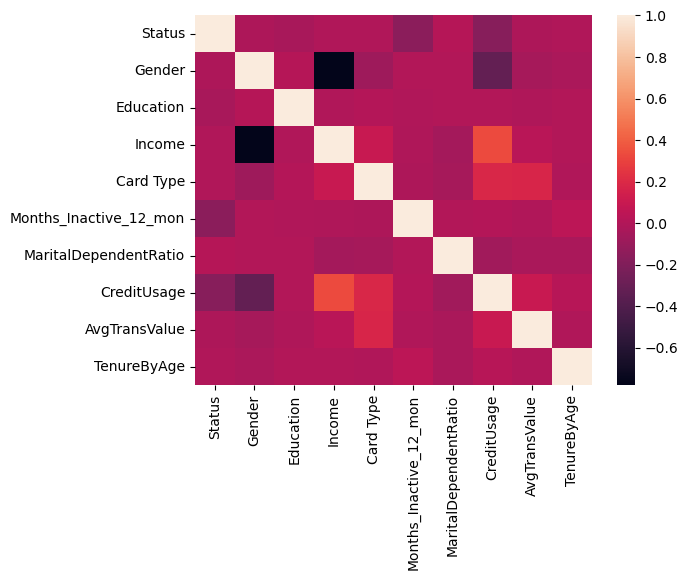

In [36]:
sns.heatmap(starter_df.corr(), fmt='.2g')

In [17]:
y = starter_df['Status']
X = starter_df.drop(columns=['Status'])

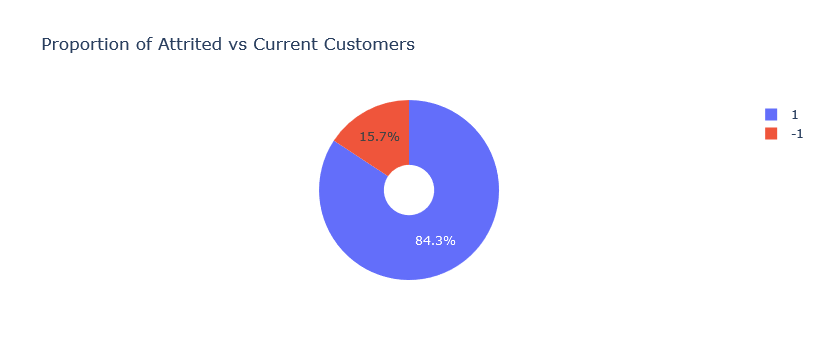

In [38]:
# plot pie chart with percentage of target data
ex.pie(starter_df, names="Status", title="Proportion of Attrited vs Current Customers", hole=0.28)

In [19]:
#Check the value counts
y.value_counts()

 1    3783
-1     707
Name: Status, dtype: int64

In [20]:
#Split features and target in to training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [21]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [22]:
#Using the Adabooster model and fit the model with training data, predict the model with testing data 
ada_model = AdaBoostClassifier(n_estimators=1000)
ada_model.fit(X_train, y_train)
ada_y_pred = ada_model.predict(X_test)


In [23]:
# print the accuracy score 
ada_accuracy = accuracy_score(y_test, ada_y_pred)
print("Ada Booster Accuracy: {:.2f}%".format(ada_accuracy * 100))

Ada Booster Accuracy: 82.19%


In [24]:
# create a dataframe and print the actual targets and testing predictions
results = pd.DataFrame({"Testing predictions": ada_y_pred,
    "Actual targets" : y_test})
results.tail()

,Testing predictions,Actual targets
3635,1,1
5954,1,1
7676,1,-1
7453,1,1
7558,1,1


In [25]:
#generate confusion matrix
ada_matrix= confusion_matrix(y_test, ada_y_pred)
ada_matrix

array([[ 61, 131],
       [ 69, 862]], dtype=int64)

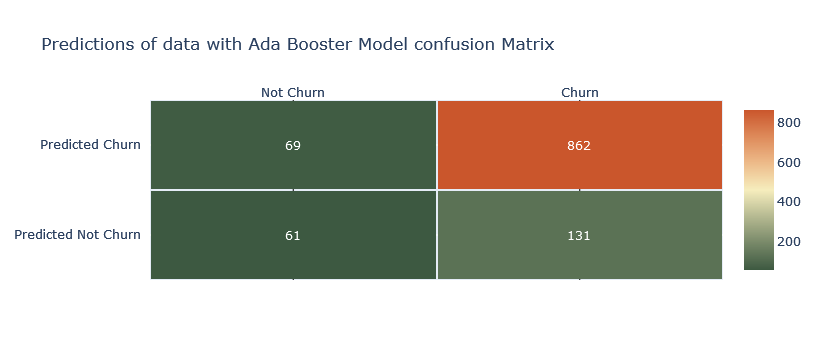

In [26]:
#plot confusion matrix using the heatmap
fig= ff.create_annotated_heatmap(ada_matrix, x=['Not Churn', 'Churn'], y=['Predicted Not Churn', 'Predicted Churn'],
                                 colorscale='Fall', xgap=2, ygap=2)
fig['data'][0]['showscale'] = True
fig.update_layout(title="Predictions of data with Ada Booster Model confusion Matrix")
fig.show()

In [43]:
#create Classification report 
print(classification_report(y_test, ada_y_pred))

              precision    recall  f1-score   support

          -1       0.47      0.32      0.38       192
           1       0.87      0.93      0.90       931

    accuracy                           0.82      1123
   macro avg       0.67      0.62      0.64      1123
weighted avg       0.80      0.82      0.81      1123



In [28]:
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)
svm_y_pred = svm_model.predict(X_test)
svm_y_pred[:10]

array([ 1, -1, -1,  1, -1, -1, -1,  1,  1,  1], dtype=int64)

In [29]:
svm_acc = accuracy_score(y_test, svm_y_pred)
print("SVM Accuracy: {:.2f}%".format(svm_acc * 100))

SVM Accuracy: 66.16%


In [30]:
confusion_matrix(y_test, svm_y_pred)

array([[ 74, 118],
       [262, 669]], dtype=int64)

In [31]:
#create Classification report 
print(classification_report(y_test, svm_y_pred))

              precision    recall  f1-score   support

          -1       0.22      0.39      0.28       192
           1       0.85      0.72      0.78       931

    accuracy                           0.66      1123
   macro avg       0.54      0.55      0.53      1123
weighted avg       0.74      0.66      0.69      1123

